# Spectrally-resolved outgoing longwave radiation (OLR) with `RRTMG_LW`

In this notebook we will demonstrate how to use `climlab.radiation.RRTMG_LW` to investigate the clear-sky, longwave response of the atmosphere to perturbations in $CO_{2}$ and SST. In particular, we will use the new `return_spectral_olr` feature to explain the behaviour of the OLR to these changes.

In [50]:
from __future__ import division, print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab

import xarray as xr

import scipy.integrate as sp  #Gives access to the ODE integration package

## Set up idealized atmospheric profiles of temperature and humidity

In this example, we will use a temperature profile which is a moist adiabat, pegged to an isothermal stratosphere at $T_{strat}=200 \mathrm{K}$. We will also assume that relative humidity is fixed (a decent first-order assumption) at a constant value of $\mathrm{RH}=0.8$.

In [2]:
def pseudoadiabat(T,p):
    """Moist adiabat"""
    return climlab.utils.thermo.pseudoadiabat(T, p)


def generate_idealized_temp_profile(SST, plevs, Tstrat=200):
    """
    Generates an idealized temperature profile with specified SST and Tstrat
    """
    solution = sp.odeint(pseudoadiabat, SST, np.flip(plevs))
    temp = solution.reshape(-1)
    temp[np.where(temp<Tstrat)] = Tstrat
    return np.flip(temp) # need to re-invert the pressure axis


In [3]:
# Set up a column state
state = climlab.column_state(num_lev=30, num_lat=1)

# Extract the pressure levels
plevs = state['Tatm'].domain.axes['lev'].points

# Set the SST
state['Ts'][:] = 300

# Set the atmospheric profile to be our idealized profile
state['Tatm'][:] = generate_idealized_temp_profile(SST=300, plevs=plevs)

Text(0, 0.5, 'Pressure (hPa)')

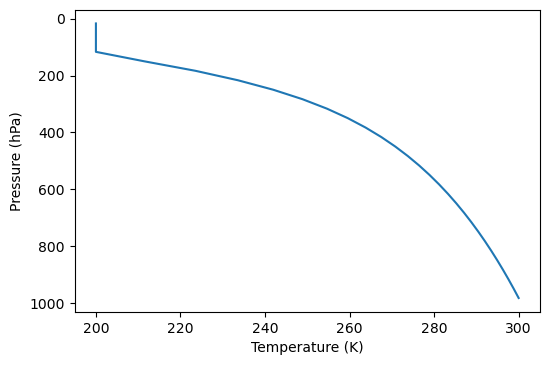

In [4]:
fig, ax = plt.subplots(dpi=100)

state['Tatm'].to_xarray().plot(ax=ax, y='lev', yincrease=False)

ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (hPa)")

Now, compute specific humidity profile using `climlab.radiation.water_vapor.FixedRelativeHumidity`

In [5]:
h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                          relative_humidity=0.8)

Text(0, 0.5, 'Pressure (hPa)')

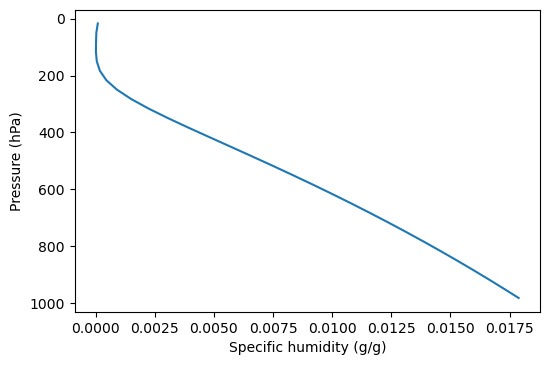

In [6]:
fig, ax = plt.subplots(dpi=100)

h2o.q.to_xarray().plot(ax=ax, y='lev', yincrease=False)

ax.set_xlabel("Specific humidity (g/g)")
ax.set_ylabel("Pressure (hPa)")

## Run the profiles through `RRTMG_LW` 

With $CO_{2}=280\mathrm{ppmv}$

In [38]:
# RRTMG radiation
rad = climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW(state=state, specific_humidity=h2o.q,  
                                               icld=0, # Clear-sky only!
                                               return_spectral_olr=True, # Just return total OLR
                                               absorber_vmr = {'CO2':280/1e6,
                                                               'CH4':0.,
                                                               'N2O':0.,
                                                               'O2':0.,
                                                               'CFC11':0.,
                                                               'CFC12':0.,
                                                               'CFC22':0.,
                                                               'CCL4':0.,
                                                               'O3':0.})

In [39]:
rad.compute_diagnostics()
olr = rad.OLR
print(olr)

[274.45220856]


# Now, wrap it all into a simple function

This will make it easier to explore the behaviour of the OLR as a function of temperature and $CO_{2}$.

In [223]:
def calc_olr(SST, CO2ppmv, spectral_olr=False, RH=0.8, Tstrat=200):
    #  Couple water vapor to radiation
    ## climlab setup
    # create surface and atmosperic domains
    state = climlab.column_state(num_lev=100, num_lat=1, water_depth=1.)
    plevs = state['Tatm'].domain.axes['lev'].points
    state['Ts'][:] = SST
    state['Tatm'][:] = generate_idealized_temp_profile(SST, plevs, Tstrat=Tstrat)

    #  fixed relative humidity
    h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                              relative_humidity=RH)
    
    # RRTMG radiation
    rad = climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW(state=state, specific_humidity=h2o.q,  
                                                   icld=0, # Clear-sky only!
                                                   return_spectral_olr=spectral_olr, 
                                                   absorber_vmr = {'CO2':CO2ppmv/1e6,
                                                                   'CH4':0.,
                                                                   'N2O':0.,
                                                                   'O2':0.,
                                                                   'CFC11':0.,
                                                                   'CFC12':0.,
                                                                   'CFC22':0.,
                                                                   'CCL4':0.,
                                                                   'O3':0.})
    rad.compute_diagnostics()
    olr = rad.OLR
    
    if spectral_olr:
        return olr, rad.OLR_spectral
    else:
        return olr

In [175]:
# Test this gives the same as before...
print(calc_olr(SST=300, CO2ppmv=280))

[274.51080141]


Now, lets iterate over a few `(SST, CO2)` pairs

In [197]:
%%time

n=20

OLRS = np.zeros((n,n))

for idx1, temp in enumerate(np.linspace(280, 290, n)):
    for idx2, co2 in enumerate(np.linspace(280, 1200, n)):
        OLRS[idx1, idx2] = calc_olr(temp, co2)

CPU times: user 8.19 s, sys: 169 ms, total: 8.36 s
Wall time: 8.42 s


Text(0, 0.5, 'SST (K)')

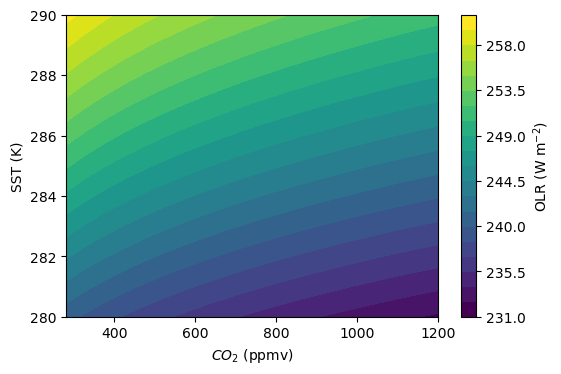

In [198]:
da=xr.DataArray(OLRS, dims=['temp', 'co2'], coords={'temp':np.linspace(280, 290, n), 'co2':np.linspace(280, 1200, n)})

fig, ax = plt.subplots(dpi=100)

p = da.plot.contourf(ax=ax, 
                    cmap='viridis', levels=20,
                     add_colorbar=False)

fig.colorbar(p, label="OLR (W m$^{-2}$)")

ax.set_xlabel("$CO_{2}$ (ppmv)")
ax.set_ylabel("SST (K)")

### Okay then! As expected we can see that, all else being equal, increasing CO$_{2}$ <span style="color:blue">decreases the OLR</span>, whereas increasing the SST <span style="color:red">increases the OLR</span> in the model.

So then, what do these changes look like in `wavenumber` space? We can investigate this using the new `return_spectral_olr` argument to `RRTMG_LW`!

First though, let's check the model reproduces the Planck curve!

In [218]:
# To do this, we'll run the model with the idealized temperature profile
# but not include the effects of water vapour (i.e., set specific_humidity=0)

# We'll also set all absorbing species to 0.

state = climlab.column_state(num_lev=100)
plevs = state['Tatm'].domain.axes['lev'].points
state['Ts'][:] = 300
state['Tatm'][:] = generate_idealized_temp_profile(SST=300, plevs=plevs, Tstrat=200)


rad1 = climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW(state=state, specific_humidity=0,  
                                           icld=0, # Clear-sky only!
                                           return_spectral_olr=True, 
                                           absorber_vmr = {'CO2':0/1e6,
                                                           'CH4':0.,
                                                           'N2O':0.,
                                                           'O2':0.,
                                                           'CFC11':0.,
                                                           'CFC12':0.,
                                                           'CFC22':0.,
                                                           'CCL4':0.,
                                                           'O3':0.})

rad1.compute_diagnostics()

In [213]:
# check that the different OLRs match up...

print(rad1.OLR_spectral.to_xarray().sum('wavenumber').values)

print(rad1.OLR)

[454.81611717]
[454.87164075]


Now, lets check we get the familiar Planck curve

/home/users/andreww/miniconda3/envs/test_env/lib/python3.9/site-packages/climlab/utils/thermo.py:185: RuntimeWarning: invalid value encountered in true_divide
  return 2*hPlanck*nu**3/c_light**2/(exp(hPlanck*nu/kBoltzmann/T)-1)


Text(0, 0.5, 'TOA flux (W/m$^{2}$/cm$^{-1}$)')

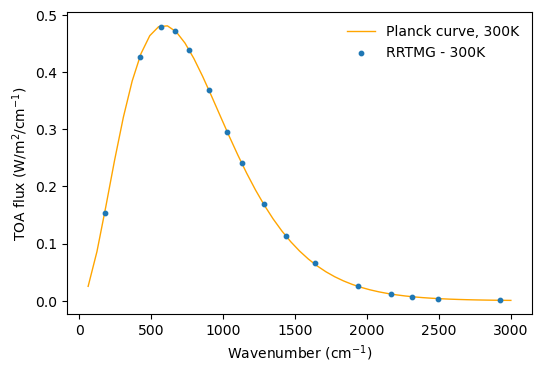

In [216]:
# Width of the spectral bands, cm-1
delwave = np.array([340, 150, 130, 70, 120, 160,
                    100, 100, 210, 90, 320, 280,
                    170, 130, 220, 650])

""" Plot ! """
fig, ax = plt.subplots(dpi=100)

planck_curve = (climlab.utils.thermo.Planck_wavenumber(np.linspace(0, 3000), 300)*100*np.pi) # 100pi factor converts from steradians/m to 1/cm

ax.plot(np.linspace(0, 3000), planck_curve, lw=1, color='orange', label="Planck curve, 300K")

# Need to normalize RRTMG spectral outputs by width of each wavenumber band
ax.scatter(rad1.OLR_spectral.to_xarray()['wavenumber'], rad1.OLR_spectral.to_xarray()/delwave, s=10, label="RRTMG - 300K", zorder=10)

ax.legend(frameon=False)

ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel("TOA flux (W/m$^{2}$/cm$^{-1}$)")

# Now, what happens when we include $CO_{2}$?

In [219]:
# To do this, we'll run the model with the idealized temperature profile
# but not include the effects of water vapour (i.e., set specific_humidity=0)

# We'll also set all absorbing species to 0.

state = climlab.column_state(num_lev=100)
plevs = state['Tatm'].domain.axes['lev'].points
state['Ts'][:] = 300
state['Tatm'][:] = generate_idealized_temp_profile(SST=300, plevs=plevs, Tstrat=200)


# Run with 
rad2 = climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW(state=state, specific_humidity=0,  
                                           icld=0, # Clear-sky only!
                                           return_spectral_olr=True, 
                                           absorber_vmr = {'CO2':10/1e6,
                                                           'CH4':0.,
                                                           'N2O':0.,
                                                           'O2':0.,
                                                           'CFC11':0.,
                                                           'CFC12':0.,
                                                           'CFC22':0.,
                                                           'CCL4':0.,
                                                           'O3':0.})

rad2.compute_diagnostics()


rad3 = climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW(state=state, specific_humidity=0,  
                                           icld=0, # Clear-sky only!
                                           return_spectral_olr=True, 
                                           absorber_vmr = {'CO2':280/1e6,
                                                           'CH4':0.,
                                                           'N2O':0.,
                                                           'O2':0.,
                                                           'CFC11':0.,
                                                           'CFC12':0.,
                                                           'CFC22':0.,
                                                           'CCL4':0.,
                                                           'O3':0.})

rad3.compute_diagnostics()

/home/users/andreww/miniconda3/envs/test_env/lib/python3.9/site-packages/climlab/utils/thermo.py:185: RuntimeWarning: invalid value encountered in true_divide
  return 2*hPlanck*nu**3/c_light**2/(exp(hPlanck*nu/kBoltzmann/T)-1)


Text(0, 0.5, 'TOA flux (W/m$^{2}$/cm$^{-1}$)')

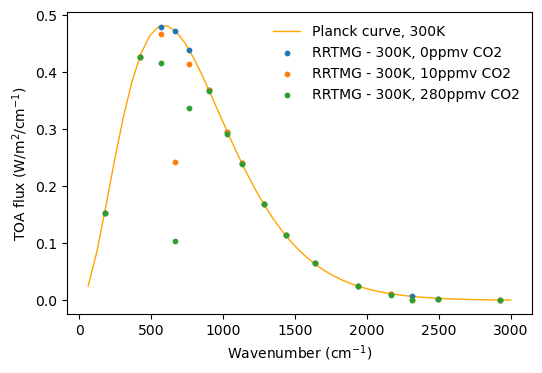

In [222]:
""" Plot ! """
fig, ax = plt.subplots(dpi=100)

planck_curve = (climlab.utils.thermo.Planck_wavenumber(np.linspace(0, 3000), 300)*100*np.pi) # 100pi factor converts from steradians/m to 1/cm

ax.plot(np.linspace(0, 3000), planck_curve, lw=1, color='orange', label="Planck curve, 300K")

# Need to normalize RRTMG spectral outputs by width of each wavenumber band
ax.scatter(rad1.OLR_spectral.to_xarray()['wavenumber'], rad1.OLR_spectral.to_xarray()/delwave, s=10, label="RRTMG - 300K, 0ppmv CO2", zorder=10)
ax.scatter(rad1.OLR_spectral.to_xarray()['wavenumber'], rad2.OLR_spectral.to_xarray()/delwave, s=10, label="RRTMG - 300K, 10ppmv CO2", zorder=10)
ax.scatter(rad1.OLR_spectral.to_xarray()['wavenumber'], rad3.OLR_spectral.to_xarray()/delwave, s=10, label="RRTMG - 300K, 280ppmv CO2", zorder=10)

ax.legend(frameon=False)

ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel("TOA flux (W/m$^{2}$/cm$^{-1}$)")

As we saw before, including $CO_{2}$ in the radiative transfer calculation reduces the total OLR (i.e., the spectral integral over what we've plotted). This happens predominantly due to absorption at the center of the $15 \mu\mathrm{m}$ $CO_{2}$ band (around $667.5 \mathrm{cm}^{-1}$). 

Note that increasing the $CO_{2}$ concentration causes a greater reduction at the center of the band, with increasing absorption at the edges (commonly referred to as the 'wings') of the band.

# What about water vapour?

Now, we'll redo the calculation, but include the specific humidity of water vapour in the call to `RRTMG_LW`.

In [224]:
# To do this, we'll run the model with the idealized temperature profile
# but not include the effects of water vapour (i.e., set specific_humidity=0)

# We'll also set all absorbing species to 0.

state = climlab.column_state(num_lev=100)
plevs = state['Tatm'].domain.axes['lev'].points
state['Ts'][:] = 300
state['Tatm'][:] = generate_idealized_temp_profile(SST=300, plevs=plevs, Tstrat=200)

#  fixed relative humidity
h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                          relative_humidity=0.8)
    
# Run with 
rad4 = climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW(state=state, specific_humidity=h2o.q,  
                                           icld=0, # Clear-sky only!
                                           return_spectral_olr=True, 
                                           absorber_vmr = {'CO2':0/1e6,
                                                           'CH4':0.,
                                                           'N2O':0.,
                                                           'O2':0.,
                                                           'CFC11':0.,
                                                           'CFC12':0.,
                                                           'CFC22':0.,
                                                           'CCL4':0.,
                                                           'O3':0.})

rad4.compute_diagnostics()

/home/users/andreww/miniconda3/envs/test_env/lib/python3.9/site-packages/climlab/utils/thermo.py:185: RuntimeWarning: invalid value encountered in true_divide
  return 2*hPlanck*nu**3/c_light**2/(exp(hPlanck*nu/kBoltzmann/T)-1)


Text(0, 0.5, 'TOA flux (W/m$^{2}$/cm$^{-1}$)')

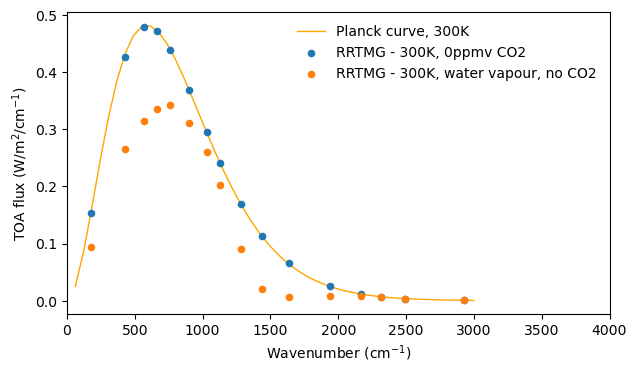

In [243]:
""" Plot ! """
fig, ax = plt.subplots(dpi=100, figsize=(7,4))

planck_curve = (climlab.utils.thermo.Planck_wavenumber(np.linspace(0, 3000), 300)*100*np.pi) # 100pi factor converts from steradians/m to 1/cm

ax.plot(np.linspace(0, 3000), planck_curve, lw=1, color='orange', label="Planck curve, 300K")

# Need to normalize RRTMG spectral outputs by width of each wavenumber band
ax.scatter(rad1.OLR_spectral.to_xarray()['wavenumber'], rad1.OLR_spectral.to_xarray()/delwave, s=20, 
           label="RRTMG - 300K, 0ppmv CO2", zorder=10)

ax.scatter(rad4.OLR_spectral.to_xarray()['wavenumber'], rad4.OLR_spectral.to_xarray()/delwave, s=20, 
           label="RRTMG - 300K, water vapour, no CO2", zorder=10)

ax.set_xlim(0, 4000)
ax.legend(frameon=False, loc='upper right')

ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel("TOA flux (W/m$^{2}$/cm$^{-1}$)")

#### Water vapour clearly also influences the OLR spectrum quite a bit! Two interesting things to note:

Firstly, water vapour is a strong absorber at a much wider range of wavelengths than $CO_{2}$!

Secondly, there is a region around 800-1500 $\mathrm{cm}^{-1}$, where water vapour doesn't cause much absorption at all! This is the well-known water vapour 'window', and it is a region where warming can efficiently escape to space from the surface. The behaviour of these 'window' region is extremely important in understanding the temperature dependence of Earth's OLR, and thus climate sensitivity (see, for example, Koll and Cronin (2018)). 

# $\textit{"Last call for orders! The water vapour window is closing!"}$

Clausius-Clapeyron tells us that the saturation water vapor pressure of water (i.e., the water-holding capacity of the atmosphere) increases by about 6-7% for every 1°C rise in temperature. One important consequence of this is that the optical depth of water vapour increases with temperature, which causes these spectral 'window' regions to eventually become optically thick. When this happens, the OLR in these regions becomes fixed and can't increase with warming. Can we see this in our model?

To do this, we'll run the model again at 280K, 300K and 320K, with a varying water vapour profile. We should see that the OLR in this window region eventually saturates to a constant value.

In [262]:
# To do this, we'll run the model with the idealized temperature profile
# but not include the effects of water vapour (i.e., set specific_humidity=0)

# We'll also set all absorbing species to 0.

state = climlab.column_state(num_lev=100)
plevs = state['Tatm'].domain.axes['lev'].points
state['Ts'][:] = 280
state['Tatm'][:] = generate_idealized_temp_profile(SST=280, plevs=plevs, Tstrat=200)

#  fixed relative humidity
h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                          relative_humidity=0.8)
    
# Run with 
rad280K = climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW(state=state, specific_humidity=h2o.q,  
                                           icld=0, # Clear-sky only!
                                           return_spectral_olr=True, 
                                           absorber_vmr = {'CO2':0/1e6,
                                                           'CH4':0.,
                                                           'N2O':0.,
                                                           'O2':0.,
                                                           'CFC11':0.,
                                                           'CFC12':0.,
                                                           'CFC22':0.,
                                                           'CCL4':0.,
                                                           'O3':0.})

rad280K.compute_diagnostics()

In [263]:
# To do this, we'll run the model with the idealized temperature profile
# but not include the effects of water vapour (i.e., set specific_humidity=0)

# We'll also set all absorbing species to 0.

state = climlab.column_state(num_lev=100)
plevs = state['Tatm'].domain.axes['lev'].points
state['Ts'][:] = 300
state['Tatm'][:] = generate_idealized_temp_profile(SST=300, plevs=plevs, Tstrat=200)

#  fixed relative humidity
h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                          relative_humidity=0.8)
    
# Run with 
rad300K = climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW(state=state, specific_humidity=h2o.q,  
                                           icld=0, # Clear-sky only!
                                           return_spectral_olr=True, 
                                           absorber_vmr = {'CO2':0/1e6,
                                                           'CH4':0.,
                                                           'N2O':0.,
                                                           'O2':0.,
                                                           'CFC11':0.,
                                                           'CFC12':0.,
                                                           'CFC22':0.,
                                                           'CCL4':0.,
                                                           'O3':0.})

rad300K.compute_diagnostics()

In [264]:
state = climlab.column_state(num_lev=100)
plevs = state['Tatm'].domain.axes['lev'].points
state['Ts'][:] = 320
state['Tatm'][:] = generate_idealized_temp_profile(SST=320, plevs=plevs, Tstrat=200)

#  fixed relative humidity
h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                          relative_humidity=0.8)
    
# Run with 
rad320K = climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW(state=state, specific_humidity=h2o.q,  
                                           icld=0, # Clear-sky only!
                                           return_spectral_olr=True, 
                                           absorber_vmr = {'CO2':0/1e6,
                                                           'CH4':0.,
                                                           'N2O':0.,
                                                           'O2':0.,
                                                           'CFC11':0.,
                                                           'CFC12':0.,
                                                           'CFC22':0.,
                                                           'CCL4':0.,
                                                           'O3':0.})

rad320K.compute_diagnostics()

/home/users/andreww/miniconda3/envs/test_env/lib/python3.9/site-packages/climlab/utils/thermo.py:185: RuntimeWarning: invalid value encountered in true_divide
  return 2*hPlanck*nu**3/c_light**2/(exp(hPlanck*nu/kBoltzmann/T)-1)
/home/users/andreww/miniconda3/envs/test_env/lib/python3.9/site-packages/climlab/utils/thermo.py:185: RuntimeWarning: invalid value encountered in true_divide
  return 2*hPlanck*nu**3/c_light**2/(exp(hPlanck*nu/kBoltzmann/T)-1)
/home/users/andreww/miniconda3/envs/test_env/lib/python3.9/site-packages/climlab/utils/thermo.py:185: RuntimeWarning: invalid value encountered in true_divide
  return 2*hPlanck*nu**3/c_light**2/(exp(hPlanck*nu/kBoltzmann/T)-1)


Text(0, 0.5, 'TOA flux (W/m$^{2}$/cm$^{-1}$)')

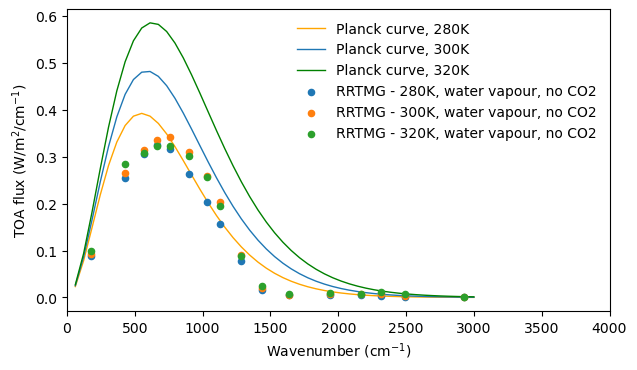

In [265]:
""" Plot ! """
fig, ax = plt.subplots(dpi=100, figsize=(7,4))

planck_curve = (climlab.utils.thermo.Planck_wavenumber(np.linspace(0, 3000), 280)*100*np.pi) # 100pi factor converts from steradians/m to 1/cm
ax.plot(np.linspace(0, 3000), planck_curve, lw=1, color='orange', label="Planck curve, 280K")

planck_curve = (climlab.utils.thermo.Planck_wavenumber(np.linspace(0, 3000), 300)*100*np.pi) # 100pi factor converts from steradians/m to 1/cm
ax.plot(np.linspace(0, 3000), planck_curve, lw=1, label="Planck curve, 300K")

planck_curve = (climlab.utils.thermo.Planck_wavenumber(np.linspace(0, 3000), 320)*100*np.pi) # 100pi factor converts from steradians/m to 1/cm
ax.plot(np.linspace(0, 3000), planck_curve, lw=1, color='green', label="Planck curve, 320K")

# Need to normalize RRTMG spectral outputs by width of each wavenumber band
ax.scatter(rad280K.OLR_spectral.to_xarray()['wavenumber'], rad280K.OLR_spectral.to_xarray()/delwave, s=20, 
           label="RRTMG - 280K, water vapour, no CO2", zorder=10)

ax.scatter(rad300K.OLR_spectral.to_xarray()['wavenumber'], rad300K.OLR_spectral.to_xarray()/delwave, s=20, 
           label="RRTMG - 300K, water vapour, no CO2", zorder=10)

ax.scatter(rad320K.OLR_spectral.to_xarray()['wavenumber'], rad320K.OLR_spectral.to_xarray()/delwave, s=20, 
           label="RRTMG - 320K, water vapour, no CO2", zorder=10)

ax.set_xlim(0, 4000)
ax.legend(frameon=False, loc='upper right')

ax.set_xlabel("Wavenumber (cm$^{-1}$)")
ax.set_ylabel("TOA flux (W/m$^{2}$/cm$^{-1}$)")

# Nice!

We can clearly see from this plot that the OLR in the water vapour windows saturates between 300K and 320K